## Generate map art using Neural Style Transfer 

In [74]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
# torch.cuda.set_device(3)

# torch.backends.cudnn.benchmark=True

In [75]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [76]:
m_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

## Input image - Eye of Sahara

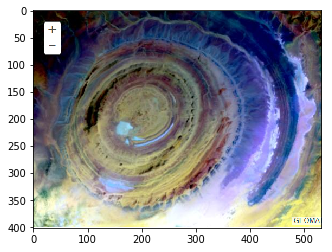

In [77]:
img_fn = 'data/stylexfer/EyeOfSahara2.png'
img = open_image(img_fn)
plt.imshow(img);

### Image processing

In [90]:
sz=288

In [79]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

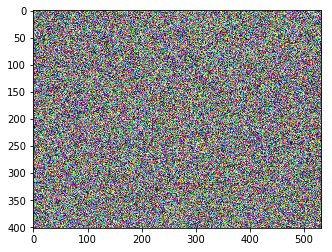

In [80]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [81]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

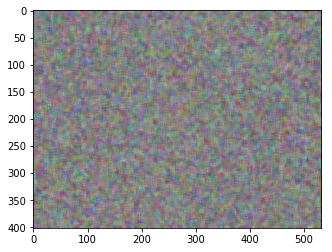

In [82]:
plt.imshow(opt_img);

In [83]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [84]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [85]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [86]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [87]:
def actn_loss(x): 
    return F.mse_loss(m_vgg(x), targ_v)*1000

In [88]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: n_iter, loss: {loss.data[0]}')
    return loss

In [89]:
n_iter=0
while n_iter <= max_iter: 
    optimizer.step(partial(step, actn_loss))

Iteration: n_iter, loss: 0.663256824016571
Iteration: n_iter, loss: 0.28715333342552185
Iteration: n_iter, loss: 0.18912574648857117
Iteration: n_iter, loss: 0.1462033987045288
Iteration: n_iter, loss: 0.12181675434112549
Iteration: n_iter, loss: 0.10545481741428375
Iteration: n_iter, loss: 0.09436909854412079
Iteration: n_iter, loss: 0.08639166504144669
Iteration: n_iter, loss: 0.08048881590366364
Iteration: n_iter, loss: 0.0761561468243599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


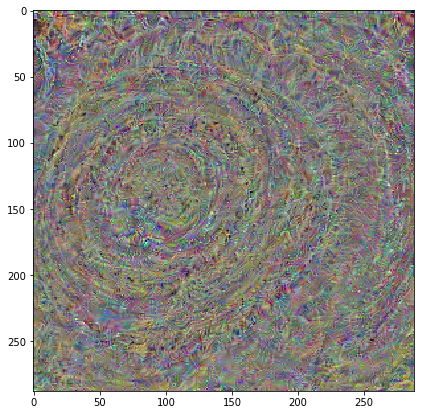

In [91]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [92]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): 
        self.features = output
        
    def close(self): self.hook.remove()

In [93]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [94]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [95]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [96]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [97]:
opt_img_v, optimizer = get_opt()

In [98]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [99]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [100]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: n_iter, loss: 0.24423928558826447
Iteration: n_iter, loss: 0.10487934947013855
Iteration: n_iter, loss: 0.06756305694580078
Iteration: n_iter, loss: 0.050306279212236404
Iteration: n_iter, loss: 0.04051889106631279
Iteration: n_iter, loss: 0.03419545665383339
Iteration: n_iter, loss: 0.029743215069174767
Iteration: n_iter, loss: 0.0264955572783947
Iteration: n_iter, loss: 0.02399607188999653
Iteration: n_iter, loss: 0.0220295749604702


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


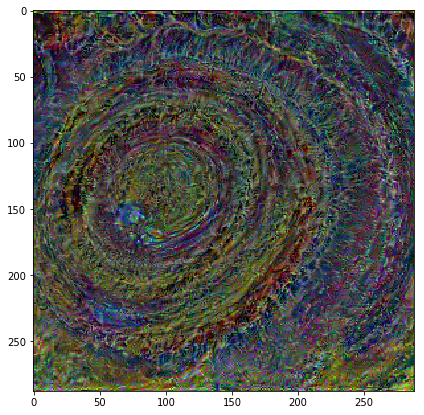

In [101]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [102]:
sf.close()

In [103]:
style_fn = 'data/stylexfer/starry-night.jpg'

In [104]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((600, 960, 3), (402, 533, 3))

## Style image - van Gogh's Starry Night

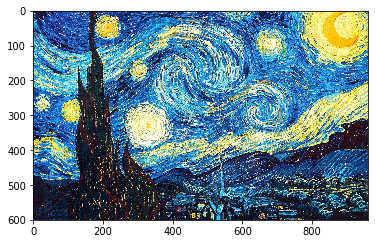

In [105]:
plt.imshow(style_img);

### Style Transfer Network

In [106]:
def scale_match(src, targ):
    h,w,_ = img.shape
    sh,sw,_ = style_img.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(style_img, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [107]:
style = scale_match(img, style_img)

((402, 533, 3), (402, 533, 3))

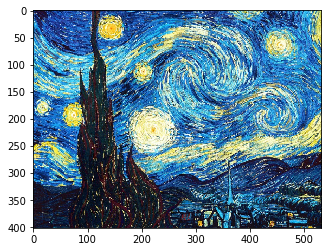

In [108]:
plt.imshow(style)
style.shape, img.shape

In [109]:
opt_img_v, optimizer = get_opt()

In [110]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [111]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [112]:
style_tfm = val_tfms(style_img)

In [113]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [114]:
def gram(input):
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target):
    return F.mse_loss(gram(input), gram(target))

In [115]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [116]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: n_iter, loss: 925.1804809570312
Iteration: n_iter, loss: 165.66058349609375
Iteration: n_iter, loss: 55.11027145385742
Iteration: n_iter, loss: 28.707841873168945
Iteration: n_iter, loss: 19.784395217895508
Iteration: n_iter, loss: 15.719663619995117
Iteration: n_iter, loss: 13.53825569152832
Iteration: n_iter, loss: 12.134035110473633
Iteration: n_iter, loss: 11.164462089538574
Iteration: n_iter, loss: 10.455910682678223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


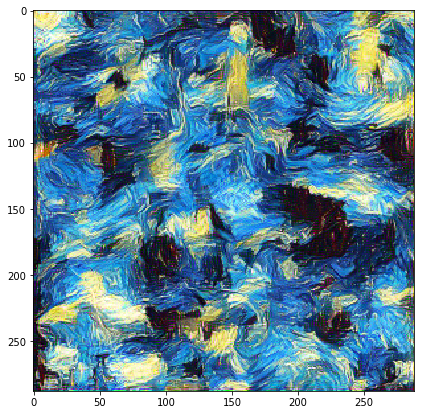

In [117]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [118]:
for sf in sfs: sf.close()

In [119]:
opt_img_v, optimizer = get_opt()

In [120]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [121]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [122]:
n_iter=0
while n_iter <= max_iter: 
    optimizer.step(partial(step,comb_loss))

Iteration: n_iter, loss: 4405.2666015625
Iteration: n_iter, loss: 1530.577880859375
Iteration: n_iter, loss: 1054.306640625
Iteration: n_iter, loss: 885.4215698242188
Iteration: n_iter, loss: 804.108154296875
Iteration: n_iter, loss: 756.4635009765625
Iteration: n_iter, loss: 726.0568237304688
Iteration: n_iter, loss: 704.5374755859375
Iteration: n_iter, loss: 688.4421997070312
Iteration: n_iter, loss: 675.8824462890625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


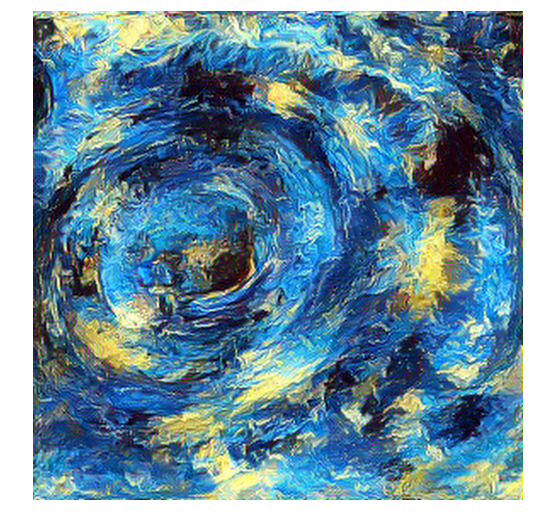

In [123]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

In [90]:
for sf in sfs: sf.close()

In [124]:
opt_img_v, optimizer = get_opt()

In [126]:
def comb_loss_content(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + 0.1*style_loss

In [127]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [128]:
n_iter=0
while n_iter <= max_iter: 
    optimizer.step(partial(step, comb_loss_content))

Iteration: n_iter, loss: 612.7393798828125
Iteration: n_iter, loss: 356.9732666015625
Iteration: n_iter, loss: 274.6669921875
Iteration: n_iter, loss: 230.89010620117188
Iteration: n_iter, loss: 205.2174072265625
Iteration: n_iter, loss: 189.152587890625
Iteration: n_iter, loss: 178.65989685058594
Iteration: n_iter, loss: 171.2051544189453
Iteration: n_iter, loss: 165.645263671875
Iteration: n_iter, loss: 161.35812377929688


In [90]:
for sf in sfs: sf.close()

## Generated Map Art

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


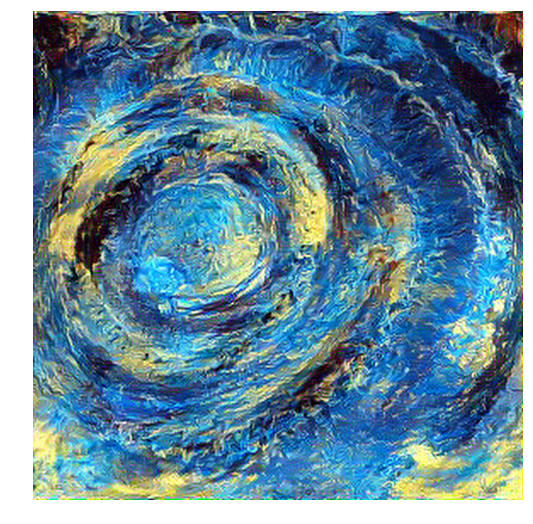

In [129]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');